In [146]:
import numpy as np
import matplotlib.pyplot as plt
import json
from sympy import *
from math import factorial

In [147]:
def extractStrokes(fileName: str):
    with open(fileName) as f:
        data = json.load(f)
    totalStrokes = len(data['strokes'])
    strokes = []
    for i in range(totalStrokes):
        if data['strokes'][i]['draw_type'] == 0:
            strokes.append(data['strokes'][i]['path'])
        else:
            continue
    print("Total strokes: ", totalStrokes)
    return strokes

In [148]:
def comb(n, r):
    if r == 0:
        return 1
    else:
        return factorial(n) // (factorial(r) * factorial(n - r))

In [149]:
def extractCoeff(num):
    x = Symbol('x')
    b0, b1, b2, b3, b4, b5 = symbols('b0 b1 b2 b3 b4 b5')
    l = [b0, b1, b2, b3, b4, b5]
    m = 0
    for i in range(num):
        m += comb(num-1, i) * (x ** i) * ((1 - x) ** (num-1 - i)) * l[i] 
    coef = Poly(m, x).coeffs()
    coef.reverse()
    coef = [[coef[i].coeff(l[j]) for j in range(num)] for i in range(num)]
    return np.array(coef, dtype=np.float64)
    #return coef

In [150]:
def getControlPoints(points, order):
    #M = np.array(extractCoeff(6), dtype=np.float64)
    M = extractCoeff(order)
    P = points
    length = len(P)
    D = [0]
    for i in range(1, length):
        D.append(D[i-1] + np.linalg.norm(P[i] - P[i-1]))   
    #print(length, D)
    S = [D[i] / D[-1] for i in range(length)]
    S = np.array(S)
    #print(S)
    T = np.tile(S, (order, 1)).transpose()
    T = np.power(T, np.arange(order))
    #print(M.shape, np.matmul(T.transpose(), T).shape)
    #print(T)
    C = np.matmul(np.matmul(np.matmul(np.linalg.inv(M), np.linalg.pinv(np.matmul(T.transpose(), T))), T.transpose()), P)
    #print(C)
    return C



In [151]:
def generatePath(points, order, T):
    M = extractCoeff(order)
    C = getControlPoints(points, order)
    #print(T.shape, M.shape, C.shape)
    path = np.matmul(np.matmul(T, M), C)
    return path

In [152]:
def removeDuplicate(points):
    newPoints = []
    for i in range(len(points)):
        if i == 0:
            newPoints.append(points[i])
        else:
            if np.linalg.norm(points[i] - points[i-1]) > 0:
                newPoints.append(points[i])
    return np.array(newPoints)

Total strokes:  41
actual strokes:  41


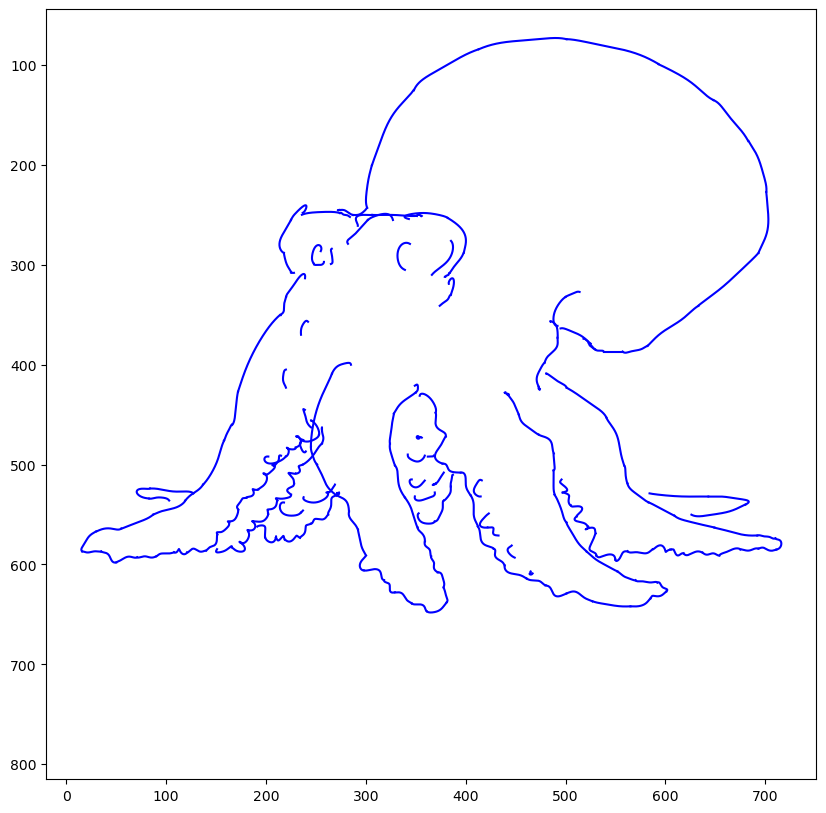

In [165]:
#points = np.array([[0, 0], [-1, 3], [4, 3], [6, 0], [7, 2.5]])
fileName = 'N036_9_1_webOctopus.json' #put the file name here
step = 0.001 #put the time step here

strokes = extractStrokes(fileName)
#print(strokes)
print('actual strokes: ', len(strokes))
time = np.arange(0,1,step)
plt.figure(figsize=(10,10))

for points in strokes:
    points = np.array(points)
    if np.unique(points, axis=0).shape[0] == 1:
        continue
    if len(points) <= 6:
        order = len(points) - 1
    else:
        order = 6
    T = np.tile(time, (order, 1)).transpose()
    T = np.power(T, np.arange(order))
    points = removeDuplicate(points)
    if len(points) > 20:
        for i in range(0, len(points), 19):
            p = points[i:i+20]
            if np.unique(p, axis=0).shape[0] == 1:
                continue
            #ran = getRange(ran, p)
            #rang = getR(rang, p)
            path = generatePath(p, order, T)

            
            px, py = path[:,0], path[:,1]
            plt.plot(px, py, 'b-')
    else:
        path = generatePath(points, order, T)
        #x, y = points[:, 0], points[:, 1]
        px, py = path[:,0], path[:,1]
        plt.plot(px, py, 'b-')
        #plt.plot(x, y, 'r.')
plt.axis('square')
plt.gca().invert_yaxis()
plt.savefig(fileName[:-5] + '_optimized.png')

    